# Maintenance Reporting

This Software is an initial effort to manipulate data using R-language in order to generate prompt reports from databases extracted from SAP.


*****************************************************************************************************************
#################################################################################################################
*****************************************************************************************************************
The Parameters we need to use are the following:

# Date 
* Month : Filter date between 01.MO.YEAR and 31.MO.YEAR
* Year  : Filter date between 01.01.YEAR and 31.12.YEAR
* YearB : Filter date between 01.01.YEARB and 31.12.YEARB

# Work Orders ID
* SWO - Standing work orders : Filter number between 70000000 and 79999999
* RWO - Regular work orders  : Filter number between 80000000 and 89999999

# Contractors ID
* Moraitis :150589
* Bousoulas:156593
* Raptis   :151355
* Karavas  :
* Doukas   :

# Contractor rates
* Moraitisrate : 17 e/h
* Bousoulasrate: 17 e/h
* Raptisrate   : 18 e/h

# General Accounts
* Service     : 6207000200
* ServiceMater: 6207000201
* ServiceEquip: 6207000202
* Material    : 6207000203

# Functional locations
* Clay Crushing      : GC05-10
* Raw Meal           : GC05-15
* Burning            : GC05-20
* Cem Grinding       : GC05-25
* Bagging & Shipping : GC05-30
* Fuel Preparation   : GC05-35
* General Services   : GC05-40

# Criticality
* Immediate             : 1
* Within one day        : 2
* Within one week       : 3
* Within one month      : 4
* At the first stop     : 5
* At scheduled Shutdown : 6

*****************************************************************************************************************
#################################################################################################################
*****************************************************************************************************************



In [1]:
# Start libraries

library(bit64)
library(dplyr)

# Parameters Input

#Month<-11
#Year<-2019
#YearB = Year-1
datem<-"01/09/19"
dateY<-"01/01/19"
dateB<-"01/01/18"
datem<-as.Date(datem,format="%d/%m/%y")
dateY<-as.Date(dateY,format="%d/%m/%y")
dateB<-as.Date(dateB,format="%d/%m/%y")

str(datem)
str(dateY)
str(dateB)

#Criticality

Immediate = 1
OneDay = 2
OneWeek = 3
OneMonth = 4
Stop = 5
Shutdown = 6

#GL Accounts

Service=6207000200
ServMat=6207000201
ServEqu=6207000202
Material=6207000203

#Contractors

Moraitis<-150589
Bousoulas<-156593
Raptis<-151355

#test<-date1+30
#test
#date1
#date1<=test


Loading required package: bit
Attaching package bit
package:bit (c) 2008-2012 Jens Oehlschlaegel (GPL-2)
creators: bit bitwhich
coercion: as.logical as.integer as.bit as.bitwhich which
operator: ! & | xor != ==
querying: print length any all min max range sum summary
bit access: length<- [ [<- [[ [[<-
for more help type ?bit

Attaching package: ‘bit’

The following object is masked from ‘package:base’:

    xor

Attaching package bit64
package:bit64 (c) 2011-2012 Jens Oehlschlaegel
creators: integer64 seq :
coercion: as.integer64 as.vector as.logical as.integer as.double as.character as.bin
logical operator: ! & | xor != == < <= >= >
arithmetic operator: + - * / %/% %% ^
math: sign abs sqrt log log2 log10
math: floor ceiling trunc round
querying: is.integer64 is.vector [is.atomic} [length] format print str
values: is.na is.nan is.finite is.infinite
aggregation: any all min max range sum prod
cumulation: diff cummin cummax cumsum cumprod
access: length<- [ [<- [[ [[<-
combine: c rep cbi

 Date[1:1], format: "2019-09-01"
 Date[1:1], format: "2019-01-01"
 Date[1:1], format: "2018-01-01"


# 1. Data Manipulation

We need to extract from SAP, insert in a separate folder the csv file and manipulate two databases:
* Goods movement
* Work Orders list

******************************************************************************************************************
##################################################################################################################
******************************************************************************************************************

In [2]:
# Input WOgoods database ************************************************

WOgoods=read.csv("WOgoods.csv",header=T)

# Date Transformation as date

WOgoods$Date<-as.Date(WOgoods$Date,format="%d/%m/%y")

# GL.Account Transformation as integer

WOgoods$GL.Account<-as.integer64(WOgoods$GL.Account)

print('')
print("***************************************************************************************************")
print("*************** Goods Database ********************************************************************")
print("***************************************************************************************************")
print('')

str(WOgoods)

# Input WOrder database ************************************************

WOrders=read.csv("WOrders.csv",header=T)

# StartDate and EndDate Transformation as date

WOrders$StartDate<-as.Date(WOrders$StartDate,format="%d/%m/%y")
WOrders$EndDate<-as.Date(WOrders$EndDate,format="%d/%m/%y")

print('')
print("***************************************************************************************************")
print("*************** Orders Database *******************************************************************")
print("***************************************************************************************************")
print('')

str(WOrders)

# Join the Databases WOgoods and WOrders

Masterdb<-right_join(WOrders,WOgoods,by='WO')

print('')
print("****************************************************************************************************")
print("*************** Master Database ********************************************************************")
print("****************************************************************************************************")
print('')

str(Masterdb)
#tbl_df(Masterdb)


[1] ""
[1] "***************************************************************************************************"
[1] "*************** Goods Database ********************************************************************"
[1] "***************************************************************************************************"
[1] ""
'data.frame':	38571 obs. of  6 variables:
 $ WO        : int  70005210 80011099 80011099 80011107 80011928 80011097 80011926 80011097 80011097 80011926 ...
 $ Date      : Date, format: "2018-02-01" "2018-02-01" ...
 $ MatCode   : int  11206939 91101927 11200021 91101930 11207385 11207385 11207213 11200155 11200206 11207213 ...
 $ Value     : num  22.1 0 120 0 -5.9 8.2 -13.6 23.8 52.5 13.6 ...
 $ Contractor: Factor w/ 324 levels "","150187","150249",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ GL.Account:integer64 2699599215 NA 2699599215 NA 2699599215 2699599215 2699599215 2699599215 ... 
[1] ""
[1] "**************************************************************************

# 2. Standing vs Regular

From the "Goods Movement" database we filter Standing and Regular Work orders by month, present and last year.
Then we sum up the costs.
The output should be the following:
* SCM / SCY / SCB - which stands for Standing WO Cost Monthly,Yearly and Year Before
* RCM / RCY / RCB - which stands for Regular  WO Cost Monthly,Yearly and Year Before
* TCM / TCY / TCB - which stands for Total       Cost Monthly,Yearly and Year Before

Three pie charts should be created based on the below percentages
* RMP / SMP       - which stands for regular / standing monthly percentage
* RYP / SYP       - which stands for regular / standing yearly percentage
* RBP / SBP       - which stands for regular / standing last year percentage

where, RMP = RCM/TCM , SMP = SCM/TCM , RYP = RCY/TCY , SYP = SCY/TCY , RBP = RCB/TCB , SBP = SCB/TCB


******************************************************************************************************************
##################################################################################################################
******************************************************************************************************************



'data.frame':	175 obs. of  17 variables:
 $ WO                : int  70005365 70005402 70005365 70005353 70005398 70005353 70005353 70005336 70005336 70005325 ...
 $ StartDate         : Date, format: "2019-01-01" "2019-01-01" ...
 $ EndDate           : Date, format: NA NA ...
 $ Equipment         : int  NA NA NA NA NA NA NA NA NA NA ...
 $ Value.x           : num  4288 9599 4288 4910 28013 ...
 $ FunctionalLocation: Factor w/ 93 levels "GC05-10-01090",..: 32 43 32 19 16 19 19 90 90 43 ...
 $ OrderType         : Factor w/ 2 levels "R","S": 2 2 2 2 2 2 2 2 2 2 ...
 $ WBS               : Factor w/ 409 levels "GC05-14-001-01",..: 384 389 384 380 381 380 380 406 406 388 ...
 $ Activity          : Factor w/ 5 levels "C","F","J","L",..: 5 4 5 5 4 5 5 5 5 5 ...
 $ Notification      : int  NA NA NA NA NA NA NA NA NA NA ...
 $ Priority          : Factor w/ 11 levels "","1","2","3",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Fun.Loc           : Factor w/ 7 levels "GC05-10","GC05-15",..: 4 5 4 3 3 3 3 7 7 5 ..

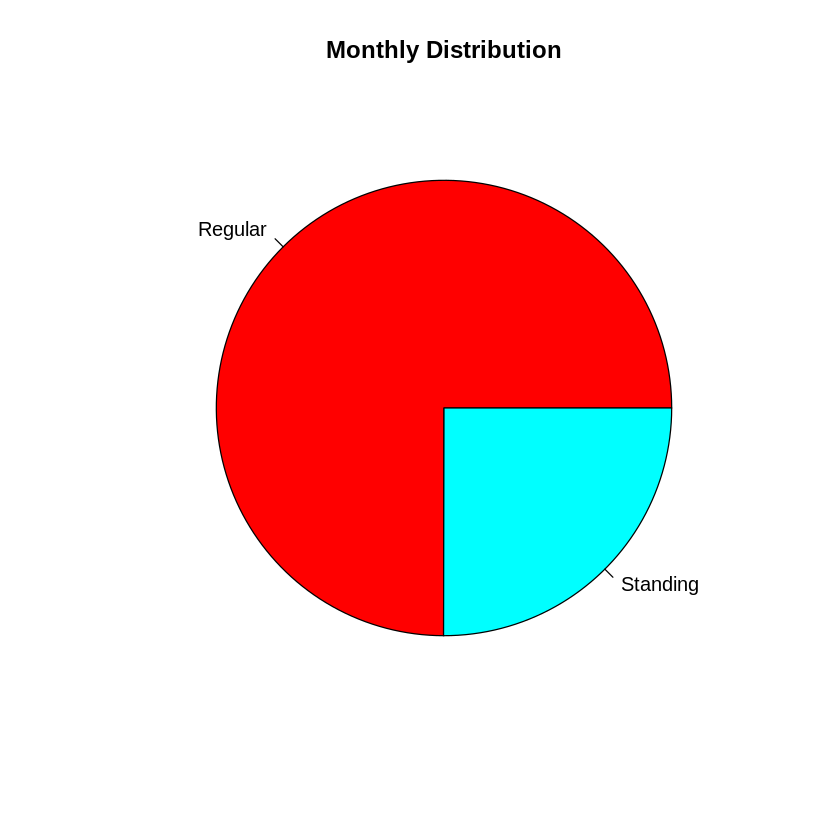

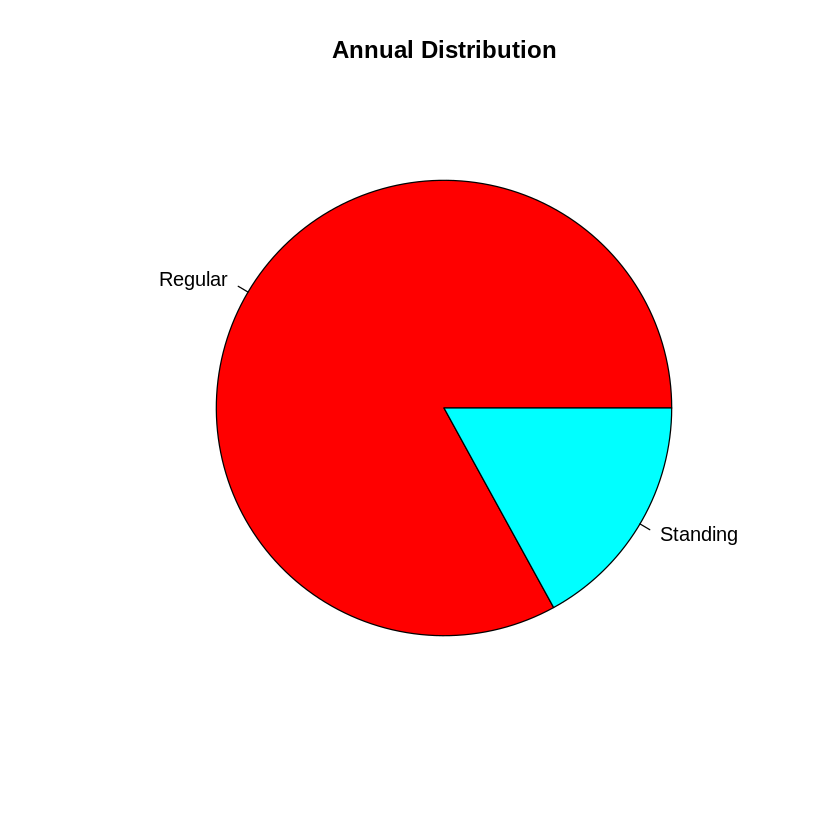

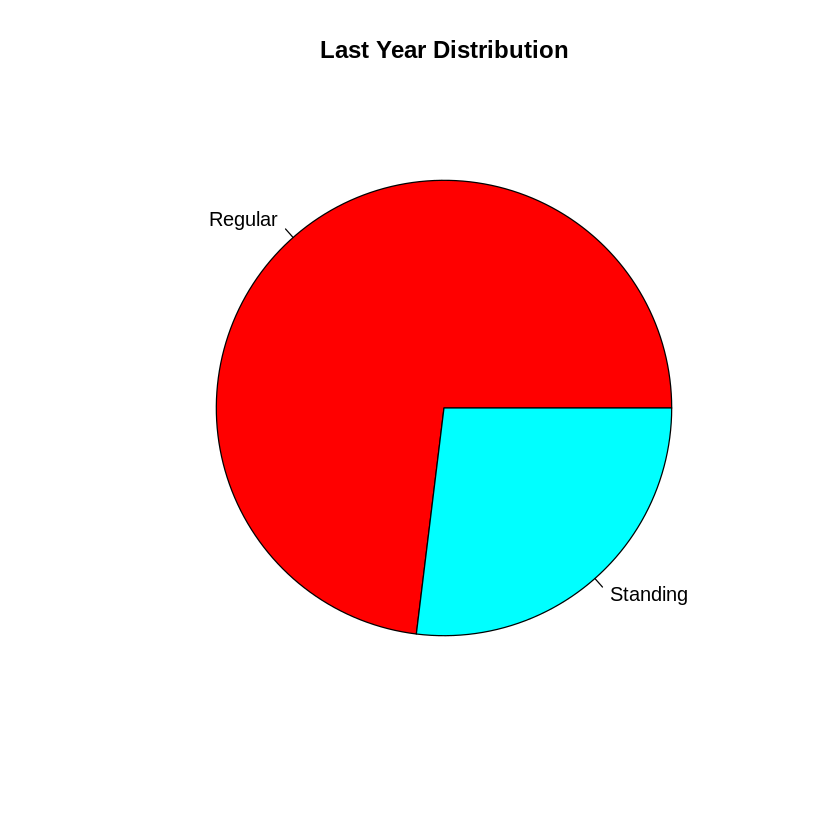

In [35]:

t1<- filter(Masterdb,Masterdb$OrderType=="S")
#str(t1)

t2<-filter(t1,Date>=datem)
str(t2)


SCMdf <- filter(Masterdb,Masterdb$OrderType=="S" & Masterdb$Date >= datem)
SCYdf <- filter(Masterdb,Masterdb$OrderType=="S" & Masterdb$Date >= dateY)
SCBdf <- filter(Masterdb,Masterdb$OrderType=="S" & Masterdb$Date >= dateB & Masterdb$Date < dateY)

#str(SCMdf)
print("*********************************************************************")
#str(SCYdf)
print("******** Standing WO Cost *******************************************")
#str(SCBdf)
print("*********************************************************************")

SCM<-sum(SCMdf$Value.y)
SCY<-sum(SCYdf$Value.y)
SCB<-sum(SCBdf$Value.y)

str(SCM)
str(SCY)
str(SCB)

#tbl_df(SCMdf)
#tbl_df(SCYdf)
#tbl_df(SCBdf)

###########################################################################################
###########################################################################################

RCMdf <- filter(Masterdb,Masterdb$OrderType=="R" & Masterdb$Date >= datem)
RCYdf <- filter(Masterdb,Masterdb$OrderType=="R" & Masterdb$Date >= dateY)
RCBdf <- filter(Masterdb,Masterdb$OrderType=="R" & Masterdb$Date >= dateB & Masterdb$Date < dateY)

#str(RCMdf)
print("*********************************************************************")
#str(RCYdf)
print("********* Regular WO cost *******************************************")
print("*********************************************************************")

RCM<-sum(RCMdf$Value.y)
RCY<-sum(RCYdf$Value.y)
RCB<-sum(RCBdf$Value.y)

str(RCM)
str(RCY)
str(RCB)

#tbl_df(RCMdf)
#tbl_df(RCYdf)
#tbl_df(RCBdf)

#########################################################################################
#########################################################################################

print("*********************************************************************")
print("******* Total Cost S+R **********************************************")
print("*********************************************************************")

TCM <- RCM+SCM
TCY <- RCY+SCY
TCB <- RCB+SCB

str(TCM)
str(TCY)
str(TCB)

########################################################################################
#####    Percentage calculation  #######################################################

print("*********************************************************************")
print("********** S-R Percentage calculation********************************")
print("*********************************************************************")

RMP <- RCM/TCM
SMP <-(1-RMP)
RYP <- RCY/TCY
SYP <- (1-RYP)
RBP <- RCB/TCB
SBP <- (1-RBP)

str(RMP)
str(SMP)
str(RYP)
str(RBP)

#############  pie plot construction #################################################

vM<-c(RMP,SMP)
vY<-c(RYP,SYP)
vB<-c(RBP,SBP)

lab1<-c("Regular","Standing")

pie(vM,lab1,main="Monthly Distribution", col = rainbow(length(vM)))
pie(vY,lab1,main="Annual Distribution", col = rainbow(length(vY)))
pie(vB,lab1,main="Last Year Distribution", col = rainbow(length(vB)))





# 3. Number of Regular WO generated

From the "Work Orders list" database we count the non zero Regular Work orders created so far this month, persent year and during last year. Furthermore,  we identify how many work orders are attached to a notification.

The output variables are the following:
* RWONM / RWONY / RWONB - which stands for regular work order number, monthly / yearly / year before,
* NZRNM / NZRNY / NZRNB - which stands for non zero regular number,   monthly / yearly / year before,
* NARNM / NARNY / NARNB - which stands for notification atached regular number monthly,yearly...

Three pie charts should be created based on the below percentages

* NARPM / NARPY / NARPB - which stands for notification attached regular percentage,monthly / yearly / year before

where NARPM = NARNM/RWONM , NARPY = NARNY/RWONY , NARPB = NARPB/RWONB 

******************************************************************************************************************
##################################################################################################################
******************************************************************************************************************

# 4. Average Regular WO cost

In order to find the Average Regular WO cost we sum the total cost of the Regular WO identified at step 3 and divide it by non zero regular WO number.

The output variables are:

* RCM2 / RCY2 / RCB2 , which stands for Regular Cost Monthly / Yearly / Year Before and 2 denotes the different database from step 2
* ARCM / ARCY / ARCB , which stands for Average Regular Cost Monthly / Yearly / Year Before

where ARCM = RCM2/NZRNM , ARCY = RCY2/NZRNY , ARCB = RCB2/NZRNB

# 5. Maintenance Cost Allocation

# 6. Contractors Cost

# 7. Contractors Average work duration

# 8. Cost distribution within the plant

# 9. Service bad actors Identifications

# 10. Criticality Distribution within the plant